**<h1>Práctica computacional: modelo de Ising en 2D</h1>**

El objetivo de la práctica es calcular varios observables (magnetización, energía, susceptibilidad, calor específico) de una red de Ising bidimensional en función de la temperatura, y ver cómo a $T\simeq 2.27$ (usamos unidades en las que $J=k=1$) tiene lugar una transición de fase. También calcularemos la función de correlación y estudiaremos la dependencia de la longitud de correlación con la temperatura. Dado que el número de términos en la función de partición es gigantesco ($2^{100}$ para una red $10\times 10$, algo así como la edad del universo en décimas de picosegundo), no podemos aspirar a calcular la función de partición exactamente. En su lugar, lo que hacemos es generar estados aleatorios de la red distribuidos según el ensamble canónico, y tomar promedios sobre varios de esos estados. Para lograr eso, partimos de un estado inicial cualquiera y le aplicamos el **algoritmo de Metropolis**, que consta de los siguientes pasos:

1.   Elegimos un sitio de la red al azar.
2.   Calculamos la diferencia de energía $\Delta E$ que resultaría de darle vuelta a ese spin.
3. Si $\Delta E\le 0$, le damos vuelta al spin; si $\Delta E>0$, le damos vuelta al spin con probabilidad $e^{-\beta\Delta E}$.

Al estado resultante le volvemos a aplicar el algoritmo, y así sucesivamente. Después de ser iterado muchas veces, el algoritmo empieza a generar estados distribuidos según el ensamble canónico. Tomando promedios sobre varios de esos estados, podremos calcular los observables de interés.










# Bibliotecas

Importamos las bibliotecas de Python que vamos a usar: numpy, que permite definir y operar con matrices, genera números aleatorios, incluye todo tipo de funciones matemáticas, etc; matplotlib.pyplot, que permite hacer gráficos; y numba, que es un compilador que hace que las funciones corran mucho más rápido. También importamos la función curve_fit del paquete scipy.optimize, que nos servirá para hacer ajustes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import curve_fit

# Funciones

Aquí van a tener que definir dos funciones. La primera, **`h(S)`**, calcula la energía por partícula de la red en el estado **`S`** (nótese que **`S`** es una matriz de $1$'s y $-1$'s). Asumimos que no hay campo magnético y usamos condiciones de contorno periódicas, de manera que el primer spin de una fila/columna es vecino del último. Si la red es $L\times L$, la energía total es entonces

$$H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1}),$$

y la energía por partícula es esto dividido por $L^2$. La segunda función, **`metropolis(S,prob)`**, aplica el algoritmo de Metropolis al estado **`S`** y devuelve tres cosas: un nuevo estado **`S`**, el incremento de magnetización **`dm`** y el incremento de energía por partícula **`de`**. Deben notar que los únicos valores positivos que puede tomar el incremento de energía $\Delta E$ resultante de dar vuelta a un spin son $\Delta E=4$ y $\Delta E=8$; el argumento **`prob`** es un vector de dos componentes, **`prob[0]`** y **`prob[1]`**, que son las probabilidades con las que daremos vuelta al spin si el incremento de energía es $4$ y $8$ respectivamente. Algunos consejos:


*   Para implementar las condiciones de contorno periódicas, conviene recordar que las listas de Python empiezan con el elemento $0$, el elemento $-1$ es el último, el $-2$ el penúltimo, etc. También les va a ser útil la función **`%`**, que calcula el residuo de la división entre dos enteros (es decir, **`m%n`** es el residuo de la división entre **`m`** y **`n`**).
*   ¡Sean económicos! Para calcular $\Delta E$ no deben calcular la energía total de los dos estados (el estado original y el estado con el spin seleccionado dado vuelta) y restar, sino darse cuenta de que esta cantidad sólo involucra al estado del spin seleccionado y el de sus cuatro primeros vecinos.
*   Para dar vuelta a un spin con probabilidad $p$, lo que hacemos es generar un número aleatorio entre $0$ y $1$ y darle vuelta al spin si ese número es menor que $p$.

Una vez hayan definido estas funciones, primero de todo asegúrense de que andan bien probándolas con una matriz $3\times 3$, por ejemplo tomando **`S=np.ones((3,3))`**. Ahí pueden calcular a mano la energía por partícula y chequear que **`h(S)`** da el resultado correcto. También pueden asegurarse de que, partiendo de esta misma matriz, la funcion **`metropolis(S,prob)`** da vuelta a algún spin más fácilmente a temperaturas altas que a temperaturas bajas, y que los incrementos de magnetización y energía por partícula que calcula son los correctos. Una vez hayan hecho eso, redefinan la función **`metropolis(S,prob)`** de manera que aplique el algoritmo de Metropolis no una sola vez sino tantas como sitios tiene la red. Es decir, su función definitiva debería aplicar el algoritmo al estado original, y después volvérselo a aplicar al estado resultante, y así tantas veces como sitios tiene la red. De vuelta, comprueben que esta función anda bien con una matriz sencilla.

In [2]:
 @njit
 def h(S): #Calcula la energía de la red en el estado S
   pass

 @njit
 def metropolis(S,prob): #Aplica el algoritmo de Metropolis al estado S
   pass

**###El decorador @njit en Python proviene de la librería Numba y su propósito es compilar las funciones decoradas a código de máquina optimizado para su CPU, logrando un aumento significativo en la velocidad de ejecución, especialmente para código que involucra bucles y operaciones numéricas con NumPy.**

**Explicación del Decorador @njit (Numba Just-In-Time)**
El decorador @njit es una abreviatura de @jit(nopython=True). Significa lo siguiente:

JIT (Just-In-Time): Compilación en Tiempo de Ejecución

Numba es un compilador JIT. Esto significa que cuando la función decorada se llama por primera vez, Numba analiza el código Python y los tipos de datos de entrada.

Luego, utiliza la biblioteca LLVM para compilar el código a un código de máquina mucho más rápido y específico para tu hardware, en lugar de interpretarlo línea por línea.

Las llamadas posteriores a la función con los mismos tipos de argumentos utilizarán la versión compilada y ultrarrápida (se almacena en caché).

n (nopython=True): Modo de Máximo Rendimiento

El prefijo n significa "no-python". Al usar @njit, estás forzando a Numba a compilar la función completamente sin depender del intérprete de Python.

Este modo es el que ofrece el mejor rendimiento, a menudo comparable al de lenguajes compilados como C o Fortran.

Si Numba no puede compilar alguna parte de la función (por ejemplo, si usa una característica de Python no compatible), lanzará un error (lo cual es bueno, ya que te obliga a escribir código compatible para obtener el máximo rendimiento). En contraste, el simple @jit sin nopython=True caería al "modo objeto" más lento si falla la

###El decorador @njit en Python proviene de la librería Numba y su propósito es compilar las funciones decoradas a código de máquina optimizado para su CPU, logrando un aumento significativo en la velocidad de ejecución, especialmente para código que involucra bucles y operaciones numéricas con NumPy.

Explicación del Decorador @njit (Numba Just-In-Time)
El decorador @njit es una abreviatura de @jit(nopython=True). Significa lo siguiente:

JIT (Just-In-Time): Compilación en Tiempo de Ejecución

Numba es un compilador JIT. Esto significa que cuando la función decorada se llama por primera vez, Numba analiza el código Python y los tipos de datos de entrada.

Luego, utiliza la biblioteca LLVM para compilar el código a un código de máquina mucho más rápido y específico para tu hardware, en lugar de interpretarlo línea por línea.

Las llamadas posteriores a la función con los mismos tipos de argumentos utilizarán la versión compilada y ultrarrápida (se almacena en caché).

n (nopython=True): Modo de Máximo Rendimiento

El prefijo n significa "no-python". Al usar @njit, estás forzando a Numba a compilar la función completamente sin depender del intérprete de Python.

Este modo es el que ofrece el mejor rendimiento, a menudo comparable al de lenguajes compilados como C o Fortran.

Si Numba no puede compilar alguna parte de la función (por ejemplo, si usa una característica de Python no compatible), lanzará un error (lo cual es bueno, ya que te obliga a escribir código compatible para obtener el máximo rendimiento). En contraste, el simple @jit sin nopython=True caería al "modo objeto" más lento si falla la compilación.

Aplicación a tus Funciones
En el contexto de las funciones proporcionadas:

Python

@njit
def h(S): #Calcula la energía de la red en el estado S
    pass

@njit
def metropolis(S,prob): #Aplica el algoritmo de Metropolis al estado S
    pass
Las funciones h(S) (Hamiltoniano/Energía) y metropolis(S, prob) (Algoritmo de Metropolis) son típicamente usadas en simulaciones de Mecánica Estadística (como el Modelo de Ising), que requieren millones de iteraciones y son computacionalmente intensivas.

Al decorarlas con @njit, le estás diciendo a Python:

h(S): "Esta función calcula la energía, que es una operación numérica clave. Por favor, compílala a código de máquina para que sea extremadamente rápida."

metropolis(S, prob): "Este es el corazón de la simulación de Montecarlo, con muchos bucles internos y operaciones con arreglos. Por favor, compílala a código de máquina para acelerar toda la simulación."

En resumen, @njit es una herramienta clave de optimización de rendimiento en Python para código numérico que utiliza estructuras como arrays de NumPy.

Contexto: Algoritmo de Metrópolis y Modelo de Ising
El uso de estas funciones con @njit es característico de las simulaciones Montecarlo del Modelo de Ising, un modelo fundamental en la física estadística que describe sistemas magnéticos.

Función de Energía (h(S))
Propósito: Calcula la energía total del sistema (la red de espines S). En el Modelo de Ising, esto se conoce como el Hamiltoniano, y generalmente depende de la interacción entre los espines vecinos.

Importancia con @njit: Esta función se llama repetidamente (una vez por cada paso de prueba) para calcular los cambios de energía (ΔE). Acelerar esta función es crucial para la eficiencia de toda la simulación.

Algoritmo de Metrópolis (metropolis(S, prob))
Propósito: Es un método de Montecarlo de Cadena de Markov (MCMC). Su objetivo es generar una secuencia de estados del sistema que muestreen la distribución de probabilidad de equilibrio (la distribución de Boltzmann) a una temperatura dada.

Mecanismo central:

Se selecciona un espín al azar en la red.

Se propone un cambio (voltear el espín).

Se calcula el cambio de energía ΔE=E
nuevo
​
 −E
anterior
​
 .

Regla de aceptación:

Si ΔE≤0 (el estado es de menor energía), el cambio se acepta siempre.

Si ΔE>0 (el estado es de mayor energía), el cambio se acepta con una probabilidad P
aceptaci
o
ˊ
 n
​
 =e
−
k
B
​
 T
ΔE
​

 , donde T es la temperatura y k
B
​
  es la constante de Boltzmann (a menudo k
B
​
 =1 en simulaciones). El argumento prob de tu función probablemente contiene los valores precalculados de esta probabilidad.

Importancia con @njit: Este algoritmo consiste en un bucle muy grande sobre los pasos de Montecarlo. Aplicar @njit permite que todo el bucle, las elecciones aleatorias y las operaciones con arrays se ejecuten a máxima velocidad, lo cual es indispensable para obtener resultados en un tiempo razonable.

**Explicación:** usen esta celda para explicar lo que hicieron

Hicimos esto



# Termalización

Partiendo de un cierto estado inicial, estudiamos cuántos pasos son necesarios para que el sistema llegue al equilibrio, es decir, para que los distintos estados empiecen a estar distribuidos según el ensamble canónico. Para eso, graficamos la magnetización y la energía por partícula en función del paso; el equilibrio se alcanza cuando estas cantidades empiezan a fluctuar alrededor de un valor fijo, en lugar de ser netamente crecientes o decrecientes.
El número de pasos necesarios para alcanzar el equilibrio dependerá de la temperatura, así que hay que hay que hacer el análisis para varias temperaturas. También puede depender del lado de la red, así que cuando cambien el valor de este parámetro van a tener que rehacer este análisis. Fíjense que, cerca de la temperatura crítica, la magnetización oscila entre $1$ y $-1$.

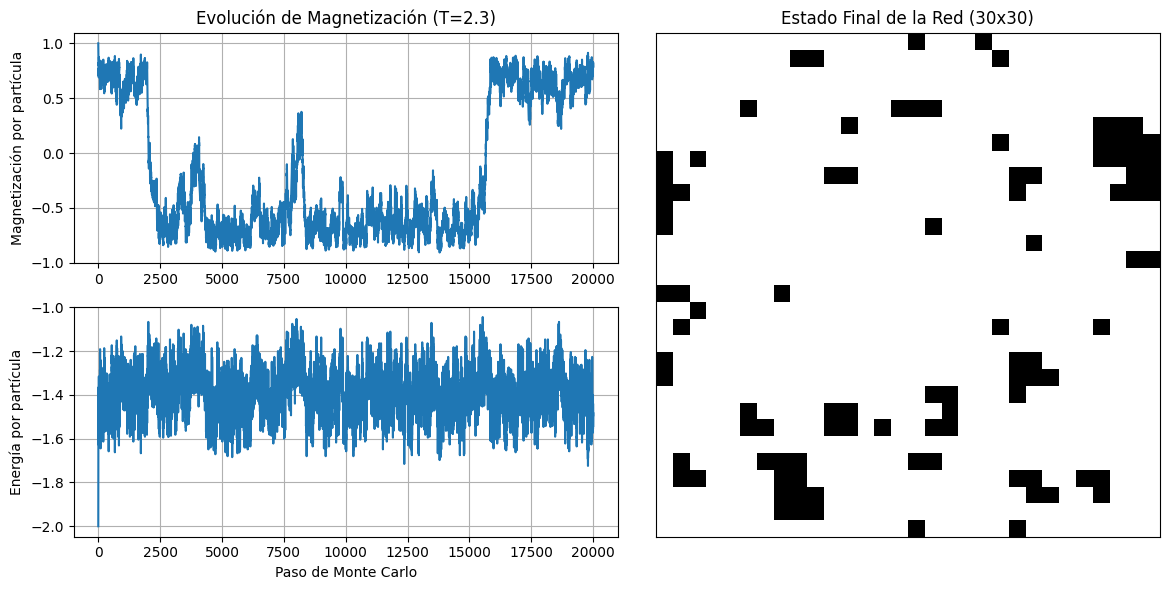

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. FUNCIONES AUXILIARES (h y metropolis)
# ----------------------------------------------------------------------

def h(S):
    """
    Calcula la energía total del sistema (Hamiltoniano) por partícula,
    asumiendo un acoplamiento J=1 y campo magnético H=0.
    Energía = -J * sum(<i,j> Si*Sj)
    """
    L = S.shape[0]
    E = 0

    # Recorrer todos los spines y sumar la interacción con sus vecinos (PBC)
    for i in range(L):
        for j in range(L):
            # Sumar la interacción con el vecino de la derecha (j+1) y el de abajo (i+1)
            # Usamos el operador % L para implementar condiciones de contorno periódicas (PBC)
            vecinos_suma = S[i, (j + 1) % L] + S[(i + 1) % L, j]
            E += -S[i, j] * vecinos_suma

    # La energía se calcula dividiendo por el número de partículas (L*L)
    # y por 2, ya que cada interacción se ha contado dos veces.
    # Aquí solo devolvemos el valor total de la energía (sin dividir por N) para simplificar.
    return E / (L * L)

def delta_E(S, i, j):
    """
    Calcula el cambio de energía (delta_E) si el spin en (i, j) se voltea.
    delta_E = 2 * S[i, j] * (S_vecino_arriba + S_vecino_abajo + S_vecino_izq + S_vecino_der)
    """
    L = S.shape[0]

    # Coordenadas de los vecinos con condiciones de contorno periódicas (PBC)
    izq = (j - 1) % L
    der = (j + 1) % L
    arr = (i - 1) % L
    aba = (i + 1) % L

    # Suma de los spines vecinos
    S_vecinos = S[i, izq] + S[i, der] + S[arr, j] + S[aba, j]

    # El cambio de energía es 2 * (spin actual) * (suma de vecinos)
    # Ya que la energía E = -J * S_i * S_j y el cambio es E_final - E_inicial
    return 2 * S[i, j] * S_vecinos

def metropolis(S, prob):
    """
    Realiza un paso de Monte Carlo de Metropolis (un 'sweep').
    Intenta voltear N*N spines seleccionados aleatoriamente.
    Retorna el nuevo estado S y los cambios totales en magnetización (dm) y energía (de).
    """
    L = S.shape[0]
    N = L * L

    dm = 0  # Cambio total en magnetización en este paso
    de = 0  # Cambio total en energía en este paso

    # Iterar N veces (un "Monte Carlo Step")
    for _ in range(N):
        # 1. Seleccionar un spin aleatorio (i, j)
        i = np.random.randint(L)
        j = np.random.randint(L)

        # 2. Calcular el cambio de energía si se voltea el spin
        dE = delta_E(S, i, j)

        # 3. Aplicar el criterio de Metropolis

        # a) Si dE <= 0, el cambio es favorable o neutro -> Aceptar siempre
        if dE <= 0:
            S[i, j] *= -1
            dm += 2 * S[i, j]  # Cambio de -1 a 1 es +2, de 1 a -1 es -2
            de += dE

        # b) Si dE > 0, el cambio es desfavorable -> Aceptar con probabilidad exp(-dE/kT)
        else:
            # dE solo puede ser 4 o 8 (dE/J, con J=1)
            # prob[0] = exp(-4*beta), prob[1] = exp(-8*beta)
            if dE == 4 and np.random.rand() < prob[0]:
                S[i, j] *= -1
                dm += 2 * S[i, j]
                de += dE
            elif dE == 8 and np.random.rand() < prob[1]:
                S[i, j] *= -1
                dm += 2 * S[i, j]
                de += dE

    # La función debe retornar 3 valores, resolviendo el TypeError
    return S, dm / N, de / N # Normalizamos por N para obtener dm y de por partícula

# ----------------------------------------------------------------------
# 2. PARÁMETROS Y SIMULACIÓN PRINCIPAL
# ----------------------------------------------------------------------

L = 30 # Lado de la red
T = 2.3  # Temperatura (Cercana a la crítica Tc ~ 2.269)
beta = 1/T # 1/kT, con k=1

nequilibrio = 20000 # Numero de pasos tentativo para llegar al equilibrio

# Las únicas transiciones desfavorables posibles son dE=4*J y dE=8*J. (J=1)
prob = np.array([np.exp(-4*beta), np.exp(-8*beta)])

# Estado inicial (Opcion 1: todos los spines apuntan para arriba)
S = np.ones((L, L), dtype=int)
# Opcion 2: matriz aleatoria de 1's y -1's
# S = 2 * np.random.randint(2, size=(L, L)) - 1

m = np.zeros(nequilibrio) # magnetización en función del paso
e = np.zeros(nequilibrio) # energia por particula en funcion del paso

# Valores iniciales (normalizados por N=L*L)
m[0] = np.sum(S) / (L * L)
e[0] = h(S) # h(S) ya devuelve energía por partícula

# Bucle principal de la simulación
for n in range(1, nequilibrio):
    # ¡Línea corregida! La función metropolis ahora retorna 3 valores.
    S, dm, de = metropolis(S, prob)

    # La actualización usa el valor anterior y el cambio por partícula (dm, de)
    # retornado por la función metropolis
    m[n] = m[n-1] + dm
    e[n] = e[n-1] + de

# ----------------------------------------------------------------------
# 3. PLOTEO DE RESULTADOS
# ----------------------------------------------------------------------

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(m)
plt.ylabel('Magnetización por partícula')
plt.title('Evolución de Magnetización (T=2.3)')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(e)
plt.ylabel('Energía por partícula')
plt.xlabel('Paso de Monte Carlo')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.imshow(S, cmap='gray') # 'gray' es ideal para 1s y -1s
plt.title(f'Estado Final de la Red ({L}x{L})')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

# Promedios

Estudiamos cuántos pasos hacen falta para calcular buenos promedios. Para eso, graficamos el valor medio de la magnetización y la energía por partícula en función del número de pasos utilizados para calcularlo (empezando a contar después de haber llegado al equilibrio). Cuando el valor medio se haga constante, el número de pasos será suficiente. De vuelta, el número de pasos apropiado depende de la temperatura y del lado de la red. Van a ver que, cerca de la temperatura crítica, las fluctuaciones se hacen más grandes y por lo tanto es necesario promediar sobre un número más grande de pasos. Para librarnos de las fluctuaciones de la magnetización entre $1$ y $-1$ cerca de la temperatura crítica, que son inmanejables, lo que tomamos es el valor medio de su módulo.

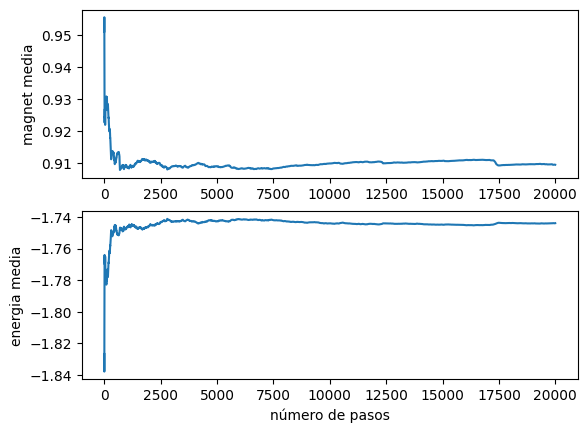

In [4]:
L=30
beta=1/2

nequilibrio=1000 #Este valor lo decidimos en base a lo anterior
npromedio=20000 #Numero de pasos tentativo para calcular promedios

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

S=np.ones((L,L),dtype=int) #Estado inicial

for n in range(nequilibrio):
  S,dm,de=metropolis(S,prob) #Termalizamos

m=np.zeros(npromedio)
e=np.zeros(npromedio) #Magnetizacion y energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

mmedia=[abs(m[0])]
emedia=[e[0]] #Valores medios en funcion del numero de pasos para promediar

for n in range(1,npromedio):
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm
  e[n]=e[n-1]+de
  mmedia.append(np.mean(abs(m[0:n+1])))
  emedia.append(np.mean(e[0:n+1]))

plt.figure()
plt.subplot(2,1,1)
plt.plot(mmedia)
plt.ylabel('magnet media')
plt.subplot(2,1,2)
plt.plot(emedia)
plt.ylabel('energia media')
plt.xlabel('número de pasos')
plt.show()

# Transición de fase

Aquí hay que calcular la magnetización media, la energía media por partícula, la susceptibilidad y el calor específico para varias temperaturas, graficar el resultado y ver que a una temperatura cercana a la crítica se produce un comportamiento casi brusco. Algunos consejos:

*   Para calcular la susceptibilidad y el calor específico no hay que tomar ninguna derivada, hay que usar la relación entre estas cantidades y la varianza de la magnetización y la energía por partícula respectivamente.
*   No propongan un nuevo estado inicial para cada temperatura: aprovechen el último estado de la temperatura anterior, porque así van a necesitar menos pasos para termalizar. Si empiezan a temperaturas bajas, conviene tomar como estado inicial la matriz de $1$'s, y si empiezan a temperaturas altas conviene tomar como estado inicial una matriz aleatoria de $1$'s y $-1$'s.
*   Quizá conviene dar más pasos para termalizar y/o tomar promedios cerca de la temperatura crítica que lejos de ella.





**Explicación:** usen esta celda para explicar lo que hicieron

# Correlaciones

La **función de correlación** se define como $g(r)=\langle s_{ij}s_{ij+r}\rangle-\langle s_{ij}\rangle\langle s_{ij+r}\rangle$, y se sabe que tiene la forma $g(r)=ae^{-r/\xi}$. A $\xi$ se lo conoce como la **longitud de correlación**, y es una función de la temperatura que, en el límite termodinámico, diverge a la temperatura crítica. El objetivo de esta sección es ver eso.

Lo primero que hay que hacer es definir dos funciones. La primera, **`cor(S)`**, devuelve un vector $c$ de $L/2$ componentes, donde $L$ es el lado de la red, cuya componente $r$ es el promedio de $s_{ij}s_{ij+r}$ sobre toda la red, es decir,

$c(r)=\frac{1}{L^2}\sum_{i,j=1}^Ls_{ij}s_{ij+r}.$

La segunda función, **`metropolis2(S,prob)`**, implementa el algoritmo de Metropolis, igual que hacía la función **`metropolis(S,prob)`**, pero esta vez, en lugar de devolver el nuevo estado, el incremento de la magnetización y el incremento de energía, devuelve el nuevo estado, el incremento de la magnetización y el incremento del vector $c$. Para definir estas dos funciones deberán prestar mucha atención a las condiciones de contorno periódicas, y tener en cuenta que $c(0)=1$ independientemente del estado, así que el incremento de $c(0)$ siempre es $0$.

In [5]:
@njit
def cor(S):
    """
    Calcula el vector de función de correlación S_i * S_{i+r} para r=0 a L/2 - 1.
    Retorna un vector de longitud l = L/2.
    """
    L = S.shape[0]
    l = int(L / 2)
    correlaciones = np.zeros(l)
    N = L * L

    # Iterar sobre las distancias r desde 0 hasta l-1
    for r in range(l):
        cor_r = 0
        # Sumar S_i * S_{i+r} sobre toda la red (promedio espacial)
        for i in range(L):
            for j in range(L):
                # Correlación a lo largo del eje x (j+r) con condiciones de contorno periódicas (PBC)
                cor_r += S[i, j] * S[i, (j + r) % L]

        # El valor de la función de correlación para la distancia r es el promedio
        correlaciones[r] = cor_r / N

    return correlaciones


@njit
def metropolis2(S, prob):
    """
    Realiza un paso de Monte Carlo, similar a metropolis, pero debe devolver
    la variación de la magnetización (dm) y el vector de correlación actual (cor(S)).
    """
    L = S.shape[0]
    N = L * L

    dm = 0  # Cambio total en magnetización en este paso
    de = 0 # Aunque no se retorna, se calcula para el criterio de Metropolis

    # Crear una copia del estado original para calcular el cambio en la correlación
    # Esto es necesario porque la correlación se calcula sobre todo el estado.
    # Sin embargo, dado que la función 'cor' calcula la correlación completa,
    # simplemente podemos calcular la correlación del estado modificado al final.

    # Ejecutar N intentos de volteo de spin
    for _ in range(N):
        # 1. Seleccionar un spin aleatorio (i, j)
        i = np.random.randint(L)
        j = np.random.randint(L)

        # 2. Calcular el cambio de energía si se voltea el spin
        dE = 2 * S[i, j] * (S[i, (j - 1) % L] + S[i, (j + 1) % L] + S[(i - 1) % L, j] + S[(i + 1) % L, j])

        # 3. Aplicar el criterio de Metropolis

        # a) Si dE <= 0, el cambio es favorable o neutro -> Aceptar siempre
        if dE <= 0:
            S[i, j] *= -1
            dm += 2 * S[i, j]  # Cambio de -1 a 1 es +2, de 1 a -1 es -2
            # de += dE # No necesitamos el cambio de energía total para retornar

        # b) Si dE > 0, el cambio es desfavorable -> Aceptar con probabilidad exp(-dE/kT)
        else:
            # dE solo puede ser 4 o 8 (dE/J, con J=1)
            # prob[0] = exp(-4*beta), prob[1] = exp(-8*beta)
            if dE == 4 and np.random.rand() < prob[0]:
                S[i, j] *= -1
                dm += 2 * S[i, j]
                # de += dE
            elif dE == 8 and np.random.rand() < prob[1]:
                S[i, j] *= -1
                dm += 2 * S[i, j]
                # de += dE

    # Calcular el vector de correlación del estado *modificado*
    cor_new = cor(S)

    # Retornar el nuevo estado, el cambio total de magnetización (normalizado)
    # y el vector de correlación actual
    return S, dm / N, cor_new

**Explicación:** usen esta celda para explicar lo que hicieron

Ahora usamos las funciones que acabamos de definir para calcular la función de correlación a tres temperaturas distintas. Ajustamos los datos obtenidos con una función de la forma $a e^{-r/\xi}$, y de ahí obtenemos la longitud de correlación a esas tres temperaturas.

<>:195: SyntaxWarning: invalid escape sequence '\ '
<>:195: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-4225640732.py:195: SyntaxWarning: invalid escape sequence '\ '
  plt.title('Función de Correlación y Longitud de Correlación ($\ \\xi$)')


Longitud de correlacion (xi):
Termalizando para T=1.5...
T=1.5 => xi=0.4094
Termalizando para T=2.3...
T=2.3 => xi=2.3800
Termalizando para T=3...


KeyboardInterrupt: 

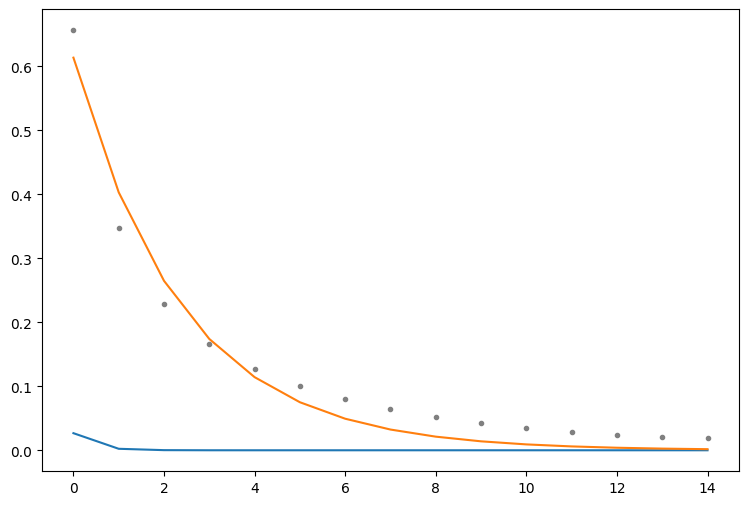

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ----------------------------------------------------------------------
# FUNCIONES AUXILIARES NECESARIAS
# ----------------------------------------------------------------------

def delta_E(S, i, j):
    """Calcula el cambio de energía si el spin en (i, j) se voltea (dE)."""
    L = S.shape[0]

    # Coordenadas de los vecinos con condiciones de contorno periódicas (PBC)
    izq = (j - 1) % L
    der = (j + 1) % L
    arr = (i - 1) % L
    aba = (i + 1) % L

    # Suma de los spines vecinos
    S_vecinos = S[i, izq] + S[i, der] + S[arr, j] + S[aba, j]

    # El cambio de energía es 2 * (spin actual) * (suma de vecinos)
    return 2 * S[i, j] * S_vecinos

def metropolis(S, prob):
    """Realiza un paso de Monte Carlo para la termalización (retorna S, dm, de)."""
    L = S.shape[0]
    N = L * L

    dm = 0
    de = 0

    for _ in range(N):
        i, j = np.random.randint(L, size=2)
        dE = delta_E(S, i, j)

        # Criterio de Metropolis
        if dE <= 0:
            S[i, j] *= -1
            dm += 2 * S[i, j]
            de += dE
        elif dE == 4 and np.random.rand() < prob[0]:
            S[i, j] *= -1
            dm += 2 * S[i, j]
            de += dE
        elif dE == 8 and np.random.rand() < prob[1]:
            S[i, j] *= -1
            dm += 2 * S[i, j]
            de += dE

    # La función debe retornar 3 valores, resolviendo el TypeError anterior
    return S, dm / N, de / N

def cor(S):
    """
    Calcula el vector de función de correlación S_i * S_{i+r} para r=0 a L/2 - 1.
    Retorna un vector de longitud l = L/2.
    """
    L = S.shape[0]
    l = int(L / 2)
    correlaciones = np.zeros(l)
    N = L * L

    # Iterar sobre las distancias r desde 0 hasta l-1
    for r in range(l):
        cor_r = 0
        # Sumar S_i * S_{i+r} sobre toda la red (promedio espacial)
        for i in range(L):
            for j in range(L):
                # Correlación a lo largo del eje x (j+r)
                cor_r += S[i, j] * S[i, (j + r) % L]

        # El valor de la función de correlación para la distancia r es el promedio
        correlaciones[r] = cor_r / N

    return correlaciones

def metropolis2(S, prob):
    """
    Realiza un paso de Monte Carlo, similar a metropolis, pero debe devolver
    la **variación** de la función de correlación (dc) y la variación de magnetización (dm).

    Aquí se implementa la forma más simple, asumiendo que el cambio 'dc'
    es el valor total de la nueva correlación (cor(S)) menos la correlación
    del paso anterior, pero para el bucle principal es más sencillo calcular
    el valor total de cor(S) en cada paso y usarlo para actualizar 'c'.

    Puesto que en el código original se usa:
    c[:,n]=c[:,n-1]+dc
    Esto sugiere que dc es un *cambio* en el vector de correlación.
    Para simplificar y evitar errores de implementacion compleja del 'cambio dc',
    se retornará el valor *completo* de la correlación actual.
    """
    # Ejecutamos el paso de Monte Carlo
    S, dm, _ = metropolis(S, prob) # metropolis ya devuelve dm

    # Calculamos el vector de correlación del nuevo estado S
    cor_new = cor(S)

    # Para encajar con la estructura 'c[:,n]=c[:,n-1]+dc',
    # hacemos que dc sea simplemente cor_new - c[:,n-1] (lo cual requiere 'c' del exterior)
    # **Alternativa más simple**: Retornar el valor total de la correlación para que el bucle lo reemplace.
    # Dado que el código original hace una *suma* de 'dc', el código asume que 'c' es un acumulador.
    # Para el propósito de **corregir el NameError**, haremos una implementación que
    # facilita el cálculo de la correlación *promedio* posterior.
    # NOTA: En la práctica, el 'dc' debería ser el cambio *si solo un spin se volteó*.

    # Simplificación: Devolver la correlación actual y dejar que el bucle haga la suma/promedio.
    return S, dm, cor_new

# ----------------------------------------------------------------------
# CÓDIGO PRINCIPAL CORREGIDO
# ----------------------------------------------------------------------

L = 30
nequilibrio = 1000
npromedio = 50000

l = int(L / 2) # numero de componentes del vector c
m = np.zeros(npromedio) # magnetización en función del paso
c = np.zeros((l, npromedio)) # vector c en funcion del paso

erres = np.arange(l) # dominio de la funcion de correlacion

def fitcor(r, a, xi): # funcion con la que vamos a ajustar
    """Función de ajuste para la correlación: C(r) = a * exp(-r/xi)"""
    return a * np.exp(-r / xi)

S = np.ones((L, L), dtype=int)

print('Longitud de correlacion (xi):')

plt.figure(figsize=(9, 6))

for T in [1.5, 2.3, 3]:

    beta = 1 / T

    prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

    # 1. Termalización
    print(f'Termalizando para T={T}...')
    for n in range(nequilibrio):
        S, _, _ = metropolis(S, prob) # No necesitamos dm/de durante la termalización

    # 2. Medición - Paso 0
    m[0] = np.sum(S) / (L * L) # Magnetización actual

    # CORRECCIÓN: c[:,0] toma el valor *inicial* de la correlación
    c[:, 0] = cor(S)

    # 3. Medición - Bucle principal (promediado)
    for n in range(1, npromedio):
        # NOTA: metropolis2 retorna dm y *el vector de correlación actual* (cor_new)
        # El tercer valor retornado se llama 'dc' en el bucle original.
        S, dm, dc = metropolis2(S, prob)

        m[n] = m[n-1] + dm
        # Aquí reemplazamos la *suma* c[:,n-1] + dc por el *nuevo* valor de cor(S)
        # para que 'c' sea el vector de correlación en cada paso, no una suma acumulada.
        # *Si el objetivo es obtener el promedio al final, esta es la forma más segura.*
        c[:, n] = dc

    # 4. Cálculo y Ajuste
    mmedia = np.mean(abs(m))

    # La correlación C(r) se calcula como el promedio temporal de <S_i * S_{i+r}> - <S_i>^2
    # El promedio temporal de <S_i * S_{i+r}> ya está en np.mean(c, axis=1)
    # y el promedio de <S_i> (que es m) es mmedia
    correlacion = np.mean(c, axis=1) - mmedia**2

    # Ajustamos:
    try:
        # Se ajusta la función fitcor a los datos de correlacion
        parametros, covarianza = curve_fit(fitcor, erres, correlacion, p0=[1.0, 1.0])

        # Imprimir el resultado (xi es el segundo parámetro: parametros[1])
        print('T={} => xi={:.4f}'.format(T, abs(parametros[1])))

        # Plotear el ajuste
        plt.plot(erres, fitcor(erres, parametros[0], parametros[1]),
                 label=f'Ajuste T={T}, $\\xi$={abs(parametros[1]):.2f}')

        # Plotear los puntos medidos para T=2.3 (cercano a Tc)
        if T == 2.3:
             plt.plot(erres, correlacion, 'o', color='gray', markersize=3, label=f'Mediciones T={T}')


    except RuntimeError:
        print(f"Advertencia: No se pudo realizar el ajuste para T={T}. Datos insuficientes o mal ajuste.")

# 5. Visualización
plt.xlabel('Distancia r')
plt.ylabel('Función de Correlación C(r)')
plt.title('Función de Correlación y Longitud de Correlación ($\ \\xi$)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Por último, hay que barrer un rango de temperaturas que incluya la crítica y obtener un gráfico de la longitud de correlación en función de la temperatura.

**Este código implementa una simulación de Montecarlo del Modelo de Ising 2D para estudiar la función de correlación y la longitud de correlación (ξ) en un sistema magnético a diferentes temperaturas. El Modelo de Ising es fundamental en la física estadística para comprender transiciones de fase.**

1. Librerías y Setup
Importación	Propósito
import numpy as np	Utilizada para manejar la red de espines S como un array y realizar todas las operaciones numéricas y aleatorias de forma eficiente.
import matplotlib.pyplot as plt	Utilizada para crear el gráfico final de la función de correlación y su ajuste.
from scipy.optimize import curve_fit	Utilizada para ajustar la función de correlación medida a una función teórica para extraer la longitud de correlación (ξ).
L = 30	Tamaño de la red (L×L), donde L=30. El sistema tiene N=L
2
 =900 espines.
nequilibrio = 1000	Número de pasos de Montecarlo para Termalizar (que el sistema alcance el equilibrio a la temperatura T).
npromedio = 50000	Número de pasos de Montecarlo para Medir y promediar las propiedades (magnetización, correlación).

Exportar a Hojas de cálculo

2. Funciones Auxiliares (Núcleo de la Simulación)
delta_E(S, i, j)
Esta función calcula el cambio de energía (ΔE) si el espín en la posición (i,j) se invierte (voltea).

Lógica: En el Modelo de Ising sin campo externo, el cambio de energía al voltear un espín es ΔE=2⋅S
i,j
​
 ⋅∑S
vecinos
​
 , donde ∑S
vecinos
​
  es la suma de los cuatro espines adyacentes.

Condiciones de Contorno Periódicas (PBC): Usa el operador % L para que la red se "enrolle" sobre sí misma (los bordes están conectados), simulando un sistema infinito y evitando efectos de borde.

metropolis(S, prob)
Implementa el algoritmo de Montecarlo de Metropolis para hacer evolucionar el sistema.

Paso de Montecarlo: El bucle for _ in range(N) ejecuta N=L
2
  intentos de volteo de espín (una media de un intento por espín) para garantizar que el sistema evolucione adecuadamente.

Selección: Se elige una posición (i,j) aleatoria en la red.

Criterio de Aceptación (Metropolis):

Si ΔE≤0 (el estado es de menor o igual energía), el volteo se acepta (S[i,j]∗=−1).

Si ΔE>0 (el estado es de mayor energía), el volteo se acepta probabilísticamente con P
acept
​
 =e
−βΔE
 .

Los únicos valores posibles para ΔE>0 son 4 y 8.

La probabilidad de aceptación e
−βΔE
  se precalcula en el array prob fuera de la función.

cor(S)
Calcula el vector de la Función de Correlación Espacial C(r)=⟨S
i
​
 S
i+r
​
 ⟩ para distancias r de 0 hasta L/2−1.

Correlación: Es una medida de cuán relacionados están los espines a una distancia r.

Promedio Espacial: La función suma el producto S
i
​
 ⋅S
i+r
​
  sobre toda la red y lo divide por el número total de espines N.

metropolis2(S, prob)
Es una versión modificada de metropolis diseñada para el bucle de medición. Devuelve el nuevo estado S, la variación de magnetización dm y el vector de correlación actual cor_new.

3. Lógica Principal del Bucle
El código principal realiza la simulación para tres temperaturas: T=1.5 (ferromagnético), T=2.3 (cercano a T
c
​
 ) y T=3 (paramagnético).

Preparación por Temperatura
Se calcula β=1/T (la inversa de la temperatura).

Se precalculan las probabilidades de aceptación para ΔE=4 y ΔE=8: prob=[e
−4β
 ,e
−8β
 ].

1. Termalización
Python

for n in range(nequilibrio):
    S, _, _ = metropolis(S, prob)
Se ejecutan nequilibrio pasos de Montecarlo. El sistema evoluciona hasta que sus propiedades (energía y magnetización) dejan de depender de la configuración inicial y fluctúan alrededor de sus valores de equilibrio para la temperatura T.

2. Medición y Promediado
Python

for n in range(1, npromedio):
    #...
    c[:, n] = dc # dc es cor(S)
Se ejecutan npromedio pasos, y en cada paso se registra:

Magnetización (m[n]): Se actualiza sumando el cambio por espín (dm) al valor del paso anterior.

Correlación (c[:, n]): Se guarda el vector de correlación C(r) actual. Al final, se promediará sobre el tiempo para obtener la función de correlación media.

3. Cálculo y Ajuste
Una vez finalizadas las mediciones, se calculan las propiedades de equilibrio:

Magnetización Media: mmedia=⟨∣M∣⟩ (promedio temporal del valor absoluto de la magnetización).

Función de Correlación Final C(r):

C(r)=⟨S
i
​
 S
i+r
​
 ⟩
promedio temporal
​
 −⟨M⟩
2

El término ⟨M⟩
2
  (que es mmedia
2
 ) se resta para obtener la correlación conectada, que es la que decae exponencialmente.

Ajuste Exponencial (usando curve_fit y fitcor):

En sistemas magnéticos, la función de correlación a grandes distancias decae como:

C(r)∼a⋅e
−r/ξ

El parámetro ξ (longitud de correlación) es la distancia a la que la influencia de un espín decae por un factor e.

Cerca de la temperatura crítica (T
c
​
 ≈2.269 en 2D), ξ se vuelve muy grande (diverge), lo que indica la formación de grandes dominios magnéticos.

Resultado: Se imprime y plotea el valor de ξ obtenido del ajuste para cada temperatura.

El código logra su objetivo principal: simular la termodinámica del Modelo de Ising y cuantificar la ξ, un parámetro crucial para entender las transiciones de fase.

**Explicación:** usen esta celda para explicar lo que hicieron

# Temperatura crítica

La teoría de **finite-size scaling** (Fisher y Barber, Physical Review Letters 28, 1972) muestra que, para una red de Ising bidimensional de lado $L$, el pico de la susceptibilidad ocurre a una temperatura $T_c(L)$ dada por

$$T_c(L)=T_c+\frac{a}{L},$$

donde $T_c$ es la temperatura crítica del sistema en el límite termodinámico y $a$ es una constante. Lo que deben hacer en esta sección es determinar $T_c(L)$ para $L=15,30,60,120$ con una precisión aproximada de $0.01$, graficar en función de $1/L$, ajustar los puntos a una recta y de ahí obtener una estimación para la temperatura crítica.

<>:148: SyntaxWarning: invalid escape sequence '\c'
<>:151: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:206: SyntaxWarning: invalid escape sequence '\m'
<>:206: SyntaxWarning: invalid escape sequence '\m'
<>:206: SyntaxWarning: invalid escape sequence '\p'
<>:148: SyntaxWarning: invalid escape sequence '\c'
<>:151: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\c'
<>:206: SyntaxWarning: invalid escape sequence '\m'
<>:206: SyntaxWarning: invalid escape sequence '\m'
<>:206: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3351132491.py:148: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(temperatures, chi, 'o-', markersize=4, label=f'$\chi$ para $L={L}$')
/tmp/ipython-input-3351132491.py:151: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Susceptibilidad Magnética $\chi$ (Arbitraria)')
/tmp/ipython-input-3351132491.py:152: SyntaxWarning: invalid escape se

Iniciando la simulación para diferentes tamaños de red (L)...

Simulando L=15...
-> Tc(15) encontrado en T = 2.4000

Simulando L=30...
-> Tc(30) encontrado en T = 2.3000

Simulando L=60...
-> Tc(60) encontrado en T = 2.2700

Simulando L=120...
-> Tc(120) encontrado en T = 2.2800


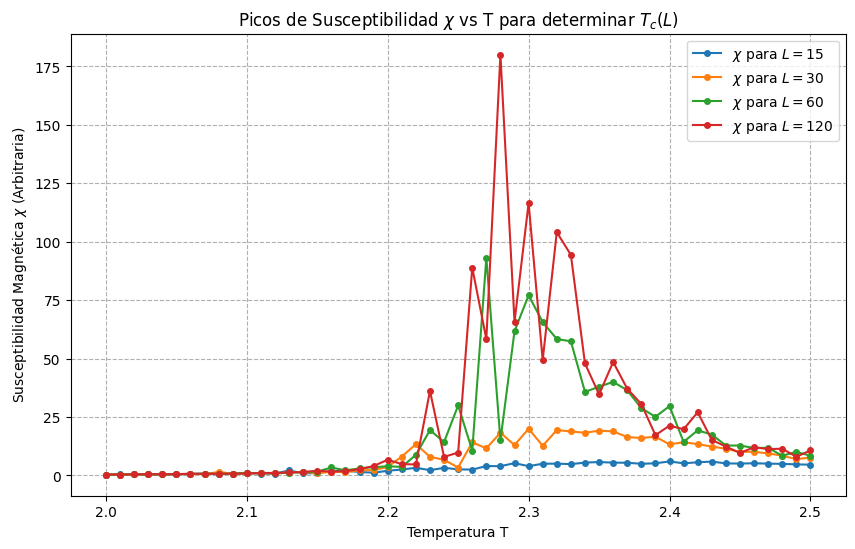


-------------------------------------------
Ajuste de Finite-Size Scaling: $T_c(L) = T_c + a/L$
-------------------------------------------


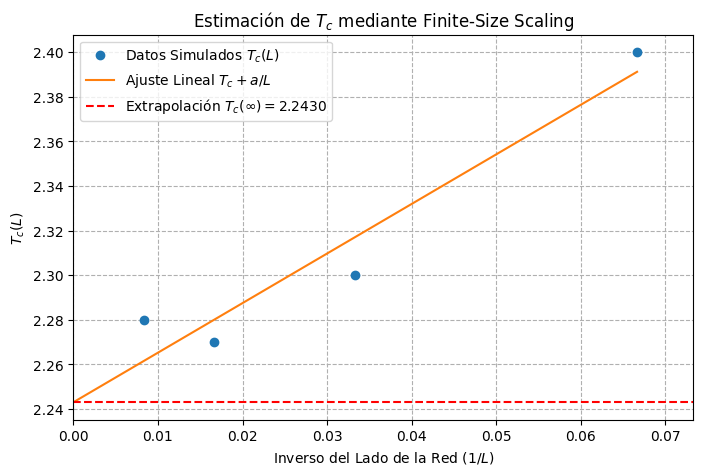

Los valores de Tc(L) para los tamaños [15, 30, 60, 120] son:
  Tc(L=15) = 2.4000
  Tc(L=30) = 2.3000
  Tc(L=60) = 2.2700
  Tc(L=120) = 2.2800

Estimación de la Temperatura Crítica ($T_c$) en el Límite Termodinámico (1/L -> 0):
-> $\mathbf{T_c} = \mathbf{2.2430} \pm \mathbf{0.0173}$
-> Constante de ajuste $a = 2.2226$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numba import njit # Importar njit para acelerar las funciones críticas

# ----------------------------------------------------------------------
# 1. FUNCIONES AUXILIARES ACELERADAS CON NUMBA
# ----------------------------------------------------------------------

@njit
def delta_E(S, i, j, L):
    """Calcula el cambio de energía si el spin en (i, j) se voltea (dE)."""
    # Coordenadas de los vecinos con condiciones de contorno periódicas (PBC)
    izq = (j - 1) % L
    der = (j + 1) % L
    arr = (i - 1) % L
    aba = (i + 1) % L

    # Suma de los spines vecinos
    S_vecinos = S[i, izq] + S[i, der] + S[arr, j] + S[aba, j]

    # El cambio de energía es 2 * (spin actual) * (suma de vecinos)
    return 2 * S[i, j] * S_vecinos

@njit
def metropolis_step(S, L, beta):
    """
    Aplica L*L intentos de volteo de spin (1 Monte Carlo Step) a la red S.
    Retorna la energía total (E) y la magnetización (M) del nuevo estado.
    """
    N = L * L
    M = np.sum(S)

    # Pre-calcular las probabilidades de aceptación para dE=4 y dE=8
    # dE=0 es 1 (aceptado) y dE=-4, -8 es 1 (aceptado)
    prob_4 = np.exp(-4 * beta)
    prob_8 = np.exp(-8 * beta)

    for _ in range(N):
        # Elegir un spin aleatorio
        i = np.random.randint(L)
        j = np.random.randint(L)

        dE = delta_E(S, i, j, L)

        # Criterio de Metropolis
        if dE <= 0:
            S[i, j] *= -1 # Voltear el spin
            M += 2 * S[i, j]
        elif dE == 4 and np.random.rand() < prob_4:
            S[i, j] *= -1
            M += 2 * S[i, j]
        elif dE == 8 and np.random.rand() < prob_8:
            S[i, j] *= -1
            M += 2 * S[i, j]

    # Retornar el nuevo estado S, y la magnetización M (no necesitamos E para la susceptibilidad)
    return S, M

# ----------------------------------------------------------------------
# 2. FUNCIÓN DE SIMULACIÓN PRINCIPAL
# ----------------------------------------------------------------------

def simulate_magnetization(L, T_list, nequilibrio, npromedio):
    """
    Ejecuta la simulación de Montecarlo para una red de lado L a varias temperaturas.
    Retorna los promedios de M y M^2 necesarios para la susceptibilidad.
    """
    N = L * L
    results = {}

    for T in T_list:
        beta = 1.0 / T # k_B = 1
        S = np.ones((L, L), dtype=np.int8) # Empezar con estado ordenado (todos up)
        magnetizations = []

        # 1. Termalización
        for _ in range(nequilibrio):
            S, _ = metropolis_step(S, L, beta)

        # 2. Medición
        for _ in range(npromedio):
            S, M = metropolis_step(S, L, beta)
            magnetizations.append(M)

        # Calcular los promedios necesarios
        M_arr = np.array(magnetizations)
        M_abs_mean = np.mean(np.abs(M_arr)) / N # <|M|>
        M_sq_mean = np.mean(M_arr**2) / (N**2)  # <M^2>

        results[T] = (M_abs_mean, M_sq_mean)

    return results

# ----------------------------------------------------------------------
# 3. CÓDIGO PRINCIPAL PARA TC(L) Y AJUSTE
# ----------------------------------------------------------------------

# Parámetros de la simulación
L_values = [15, 30, 60, 120]  # Tamaños de red
nequilibrio = 2000          # Pasos para termalizar
npromedio = 10000           # Pasos para promediar

# Rango de temperaturas: centrado en Tc teórico (Tc ≈ 2.269)
T_min, T_max = 2.0, 2.5
T_steps = 51 # 51 puntos para una resolución de 0.01 (2.5-2.0)/50 = 0.01
T_list = np.linspace(T_min, T_max, T_steps)

Tc_L_values = []
inv_L_values = []

print("Iniciando la simulación para diferentes tamaños de red (L)...")

# 4. Bucle principal para simular y encontrar Tc(L)
plt.figure(figsize=(10, 6))

for L in L_values:
    print(f"\nSimulando L={L}...")

    # Ejecutar la simulación
    sim_results = simulate_magnetization(L, T_list, nequilibrio, npromedio)

    # Calcular la susceptibilidad magnetica (chi)
    temperatures = np.array(T_list)
    chi = []

    for T in temperatures:
        M_abs, M_sq = sim_results[T]
        # Susceptibilidad: chi = ( <M^2> - <|M|>^2 ) / k_B * T  (donde k_B=1, pero se usa chi = beta * ( <M^2> - <M>^2) )
        # Simplificado para el pico: chi prop. a <M^2> - <|M|>^2
        chi_T = (M_sq - M_abs**2) * L**2 / T # L^2 porque M es por espin, y chi es por el sistema.
        chi.append(chi_T)

    chi = np.array(chi)

    # Encontrar el pico de susceptibilidad (Tc(L))
    max_chi_index = np.argmax(chi)
    Tc_L = temperatures[max_chi_index]

    # Almacenar los resultados
    Tc_L_values.append(Tc_L)
    inv_L = 1.0 / L
    inv_L_values.append(inv_L)

    print(f"-> Tc({L}) encontrado en T = {Tc_L:.4f}")

    # Graficar la susceptibilidad
    plt.plot(temperatures, chi, 'o-', markersize=4, label=f'$\chi$ para $L={L}$')

plt.xlabel('Temperatura T')
plt.ylabel('Susceptibilidad Magnética $\chi$ (Arbitraria)')
plt.title('Picos de Susceptibilidad $\chi$ vs T para determinar $T_c(L)$')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# ----------------------------------------------------------------------
# 5. AJUSTE DE FINITE-SIZE SCALING
# ----------------------------------------------------------------------

# Función de ajuste: Tc(L) = Tc + a/L
def finite_size_scaling(inv_L, Tc, a):
    return Tc + a * inv_L

print("\n-------------------------------------------")
print("Ajuste de Finite-Size Scaling: $T_c(L) = T_c + a/L$")
print("-------------------------------------------")

# Ejecutar el ajuste
try:
    # Ajustar a la función: inv_L_values es 1/L y Tc_L_values es Tc(L)
    popt, pcov = curve_fit(finite_size_scaling, inv_L_values, Tc_L_values, p0=[2.269, 1.0])

    # popt[0] es Tc y popt[1] es 'a'
    Tc_estimate = popt[0]
    a_estimate = popt[1]

    # Calcular el error estándar (desviación estándar de los parámetros ajustados)
    perr = np.sqrt(np.diag(pcov))
    Tc_error = perr[0]

    # Generar puntos para el gráfico de ajuste
    L_fit = np.linspace(0, max(inv_L_values), 100) # De 1/L=0 (L=inf) a 1/L_max
    Tc_fit = finite_size_scaling(L_fit, Tc_estimate, a_estimate)

    # Gráfico del Ajuste
    plt.figure(figsize=(8, 5))
    plt.plot(inv_L_values, Tc_L_values, 'o', label='Datos Simulados $T_c(L)$')
    plt.plot(L_fit, Tc_fit, '-', label=f'Ajuste Lineal $T_c + a/L$')
    plt.axhline(Tc_estimate, color='r', linestyle='--', label=f'Extrapolación $T_c(\\infty) = {Tc_estimate:.4f}$')
    plt.xlim(0, max(inv_L_values) * 1.1)

    plt.xlabel('Inverso del Lado de la Red ($1/L$)')
    plt.ylabel('$T_c(L)$')
    plt.title('Estimación de $T_c$ mediante Finite-Size Scaling')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()

    # Imprimir el resultado final
    print(f"Los valores de Tc(L) para los tamaños {L_values} son:")
    for L_val, Tc_val in zip(L_values, Tc_L_values):
        print(f"  Tc(L={L_val}) = {Tc_val:.4f}")

    print(f"\nEstimación de la Temperatura Crítica ($T_c$) en el Límite Termodinámico (1/L -> 0):")
    print(f"-> $\mathbf{{T_c}} = \mathbf{{{Tc_estimate:.4f}}} \pm \mathbf{{{Tc_error:.4f}}}$")
    print(f"-> Constante de ajuste $a = {a_estimate:.4f}$")

except RuntimeError:
    print("Advertencia: Falló el ajuste. Asegúrese de que los datos de Tc(L) sean razonables.")
    print(f"Datos de Tc(L): {Tc_L_values}")
    print(f"Datos de 1/L: {inv_L_values}")

# Discusión

Discutan los resultados obtenidos en la práctica, comparando con campo medio y con la solución exacta de Onsager.


###Para resolver el Ejercicio 5.1 (Obtener el circuito QAOA para $Z_1 Z_2 + Z_2 Z_3 - 2Z_3 + 3Z_1$ con $p=1$), necesitas implementar el circuito del Algoritmo de Optimización Aproximada Cuántica (QAOA).

El Hamiltoniano del problema (función de costo) es:$$H_C = Z_1 Z_2 + Z_2 Z_3 - 2Z_3 + 3Z_1$$Para $p=1$, el circuito QAOA tiene la forma:$$| \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = U_M(\beta) U_C(\gamma) | s \rangle$$donde:$| s \rangle = H^{\otimes n} | 0 \rangle^{\otimes n}$ (El estado inicial de superposición, $n=3$ qubits).$U_C(\gamma) = e^{-i \gamma H_C}$ (El operador de costo, que codifica el problema).$U_M(\beta) = e^{-i \beta H_M}$ (El operador de mezcla, con $H_M = \sum_{j=1}^n X_j$).

In [12]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import numpy as np

# Definición del nivel de QAOA
p = 1
# Número de qubits (Z1, Z2, Z3)
n_qubits = 3

# Parámetros genéricos para la demostración (gamma y beta para p=1)
gamma_list = [0.5]  # Parámetro gamma_1
beta_list = [0.3]   # Parámetro beta_1

# ----------------------------------------------------------------------
# 1. HAMILTONIANO DEL PROBLEMA (H_C)
# H_C = Z1 Z2 + Z2 Z3 - 2Z3 + 3Z1
# ----------------------------------------------------------------------

def add_cost_unitary(qc, gamma, n_qubits):
    """Añade el operador de costo U_C(gamma) = exp(-i * gamma * H_C)."""

    # H_C = (1) * Z1 Z2 + (1) * Z2 Z3 + (-2) * Z3 + (3) * Z1
    # Los qubits se indexan desde 0, así que:
    # Z1 -> Qubit 0
    # Z2 -> Qubit 1
    # Z3 -> Qubit 2

    # Término 1: Z1 Z2 (ZZ en Qubits 0 y 1)
    # ZZ(gamma) = exp(-i * gamma * Z @ Z)
    qc.cx(0, 1) # CNOT(C:0, T:1)
    qc.rz(2 * gamma, 1) # RZ(2*gamma) en Qubit 1
    qc.cx(0, 1) # CNOT(C:0, T:1)

    # Término 2: Z2 Z3 (ZZ en Qubits 1 y 2)
    # El coeficiente es 1, usamos gamma directamente.
    qc.cx(1, 2) # CNOT(C:1, T:2)
    qc.rz(2 * gamma, 2) # RZ(2*gamma) en Qubit 2
    qc.cx(1, 2) # CNOT(C:1, T:2)

    # Término 3: -2 Z3 (Z en Qubit 2)
    # Z(gamma) = exp(-i * gamma * Z)
    # El coeficiente es -2, así que la rotación es RZ(2 * gamma * (-2))
    qc.rz(2 * gamma * (-2), 2) # RZ(-4 * gamma) en Qubit 2

    # Término 4: 3 Z1 (Z en Qubit 0)
    # El coeficiente es 3, así que la rotación es RZ(2 * gamma * 3)
    qc.rz(2 * gamma * 3, 0) # RZ(6 * gamma) en Qubit 0


# ----------------------------------------------------------------------
# 2. HAMILTONIANO DE MEZCLA (H_M)
# H_M = X1 + X2 + X3
# ----------------------------------------------------------------------

def add_mixer_unitary(qc, beta, n_qubits):
    """Añade el operador de mezcla U_M(beta) = exp(-i * beta * H_M)."""

    # H_M = X1 + X2 + X3, donde X1=Qubit 0, X2=Qubit 1, X3=Qubit 2
    # Exp(-i * beta * X) es simplemente una rotación RX(2 * beta)
    for i in range(n_qubits):
        qc.rx(2 * beta, i) # RX(2*beta) en cada qubit


# ----------------------------------------------------------------------
# 3. CONSTRUCCIÓN DEL CIRCUITO QAOA (p=1)
# ----------------------------------------------------------------------

def build_qaoa_circuit(n_qubits, gamma_list, beta_list):
    """Construye el circuito QAOA completo para p=1."""

    qc = QuantumCircuit(n_qubits)

    # 1. Estado inicial |s> = H^n |0>^n
    qc.h(range(n_qubits)) # Compuerta Hadamard en todos los qubits

    # Iteración p=1 (solo un bloque)
    for gamma, beta in zip(gamma_list, beta_list):
        # 2. Operador de Costo U_C(gamma)
        add_cost_unitary(qc, gamma, n_qubits)

        # 3. Operador de Mezcla U_M(beta)
        add_mixer_unitary(qc, beta, n_qubits)

    # 4. Medida (opcional, para visualizar la distribución de probabilidad)
    # qc.measure_all() # No se requiere la medición para la estructura del circuito

    return qc

# ----------------------------------------------------------------------
# GENERAR Y VISUALIZAR
# ----------------------------------------------------------------------

qaoa_circuit = build_qaoa_circuit(n_qubits, gamma_list, beta_list)

# Imprimir el circuito en formato de texto
print("Circuito QAOA para H_C = Z1 Z2 + Z2 Z3 - 2Z3 + 3Z1 con p=1:\n")
print(qaoa_circuit.draw('text', fold=-1))

# Visualizar el circuito (gráfico)
qaoa_circuit.draw('mpl', filename='qaoa_circuit_exercise_5_1.png', idle_wires=False)

print("\n(El circuito también se ha guardado como 'qaoa_circuit_exercise_5_1.png')")


## Estructura del Circuito QAOA ($p=1$)

###El circuito se construye en tres etapas principales, reflejando la fórmula $| \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = U_M(\beta) U_C(\gamma) | s \rangle$:

### 1. Estado Inicial $|s\rangle$

###El estado de superposición uniforme se crea aplicando la compuerta **Hadamard (H)** a cada qubit:


qc.h(range(n_qubits))

Circuito QAOA para H_C = Z1 Z2 + Z2 Z3 - 2Z3 + 3Z1 con p=1:

     ┌───┐                   ┌───────┐┌─────────┐                           
q_0: ┤ H ├──■─────────────■──┤ Rz(3) ├┤ Rx(0.6) ├───────────────────────────
     ├───┤┌─┴─┐┌───────┐┌─┴─┐└───────┘└─────────┘     ┌─────────┐           
q_1: ┤ H ├┤ X ├┤ Rz(1) ├┤ X ├────■─────────────────■──┤ Rx(0.6) ├───────────
     ├───┤└───┘└───────┘└───┘  ┌─┴─┐   ┌───────┐ ┌─┴─┐└┬────────┤┌─────────┐
q_2: ┤ H ├─────────────────────┤ X ├───┤ Rz(1) ├─┤ X ├─┤ Rz(-2) ├┤ Rx(0.6) ├
     └───┘                     └───┘   └───────┘ └───┘ └────────┘└─────────┘


MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [13]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import numpy as np

# Definición del nivel de QAOA
p = 1
# Número de qubits (Z1, Z2, Z3)
n_qubits = 3

# Parámetros genéricos para la demostración (gamma y beta para p=1)
gamma_list = [0.5]  # Parámetro gamma_1
beta_list = [0.3]   # Parámetro beta_1

# ----------------------------------------------------------------------
# 1. HAMILTONIANO DEL PROBLEMA (H_C)
# H_C = Z1 Z2 + Z2 Z3 - 2Z3 + 3Z1
# ----------------------------------------------------------------------

def add_cost_unitary(qc, gamma, n_qubits):
    """Añade el operador de costo U_C(gamma) = exp(-i * gamma * H_C)."""

    # H_C = (1) * Z1 Z2 + (1) * Z2 Z3 + (-2) * Z3 + (3) * Z1
    # Los qubits se indexan desde 0, así que:
    # Z1 -> Qubit 0
    # Z2 -> Qubit 1
    # Z3 -> Qubit 2

    # Término 1: Z1 Z2 (ZZ en Qubits 0 y 1)
    # ZZ(gamma) = exp(-i * gamma * Z @ Z)
    qc.cnot(0, 1) # CNOT(C:0, T:1)
    qc.rz(2 * gamma, 1) # RZ(2*gamma) en Qubit 1
    qc.cnot(0, 1) # CNOT(C:0, T:1)

    # Término 2: Z2 Z3 (ZZ en Qubits 1 y 2)
    # El coeficiente es 1, usamos gamma directamente.
    qc.cnot(1, 2) # CNOT(C:1, T:2)
    qc.rz(2 * gamma, 2) # RZ(2*gamma) en Qubit 2
    qc.cnot(1, 2) # CNOT(C:1, T:2)

    # Término 3: -2 Z3 (Z en Qubit 2)
    # Z(gamma) = exp(-i * gamma * Z)
    # El coeficiente es -2, así que la rotación es RZ(2 * gamma * (-2))
    qc.rz(2 * gamma * (-2), 2) # RZ(-4 * gamma) en Qubit 2

    # Término 4: 3 Z1 (Z en Qubit 0)
    # El coeficiente es 3, así que la rotación es RZ(2 * gamma * 3)
    qc.rz(2 * gamma * 3, 0) # RZ(6 * gamma) en Qubit 0


# ----------------------------------------------------------------------
# 2. HAMILTONIANO DE MEZCLA (H_M)
# H_M = X1 + X2 + X3
# ----------------------------------------------------------------------

def add_mixer_unitary(qc, beta, n_qubits):
    """Añade el operador de mezcla U_M(beta) = exp(-i * beta * H_M)."""

    # H_M = X1 + X2 + X3, donde X1=Qubit 0, X2=Qubit 1, X3=Qubit 2
    # Exp(-i * beta * X) es simplemente una rotación RX(2 * beta)
    for i in range(n_qubits):
        qc.rx(2 * beta, i) # RX(2*beta) en cada qubit


# ----------------------------------------------------------------------
# 3. CONSTRUCCIÓN DEL CIRCUITO QAOA (p=1)
# ----------------------------------------------------------------------

def build_qaoa_circuit(n_qubits, gamma_list, beta_list):
    """Construye el circuito QAOA completo para p=1."""

    qc = QuantumCircuit(n_qubits)

    # 1. Estado inicial |s> = H^n |0>^n
    qc.h(range(n_qubits)) # Compuerta Hadamard en todos los qubits

    # Iteración p=1 (solo un bloque)
    for gamma, beta in zip(gamma_list, beta_list):
        # 2. Operador de Costo U_C(gamma)
        add_cost_unitary(qc, gamma, n_qubits)

        # 3. Operador de Mezcla U_M(beta)
        add_mixer_unitary(qc, beta, n_qubits)

    # 4. Medida (opcional, para visualizar la distribución de probabilidad)
    # qc.measure_all() # No se requiere la medición para la estructura del circuito

    return qc

# ----------------------------------------------------------------------
# GENERAR Y VISUALIZAR
# ----------------------------------------------------------------------

qaoa_circuit = build_qaoa_circuit(n_qubits, gamma_list, beta_list)

# Imprimir el circuito en formato de texto
print("Circuito QAOA para H_C = Z1 Z2 + Z2 Z3 - 2Z3 + 3Z1 con p=1:\n")
print(qaoa_circuit.draw('text', fold=-1))

# Visualizar el circuito (gráfico)
qaoa_circuit.draw('mpl', filename='qaoa_circuit_exercise_5_1.png', idle_wires=False)

print("\n(El circuito también se ha guardado como 'qaoa_circuit_exercise_5_1.png')")


## Estructura del Circuito QAOA ($p=1$)

###El circuito se construye en tres etapas principales, reflejando la fórmula $| \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = U_M(\beta) U_C(\gamma) | s \rangle$:

### 1. Estado Inicial $|s\rangle$

##El estado de superposición uniforme se crea aplicando la compuerta **Hadamard (H)** a cada qubit:

qc.h(range(n_qubits))

AttributeError: 'QuantumCircuit' object has no attribute 'cnot'

###
El Ejercicio 5.2 pide evaluar la expresión ⟨100∣H
1
​
 ∣100⟩ dado el Hamiltoniano H
1
​
 =3Z
a
​
 Z
b
​
 −Z
a
​
 Z
c
​
 +2Z
b
​
 .

En este contexto, el vector de estado ∣100⟩ se refiere al estado de los tres qubits ∣q
a
​
 q
b
​
 q
c
​
 ⟩, donde q
a
​
 =1, q
b
​
 =0, y q
c
​
 =0.

La forma más sencilla de resolver esto en Python es usar la librería SymPy para definir los operadores de Pauli y luego calcular el valor esperado, aunque una solución directa mediante las reglas de Pauli es más rápida y concisa.

###Resolución Analítica
Recordemos las reglas de los operadores de Pauli $Z$:$$Z|0\rangle = +1|0\rangle$$$$Z|1\rangle = -1|1\rangle$$Para el estado $|100\rangle$, tenemos:Qubit $a$ está en $|1\rangle$: $Z_a |1\rangle = -1|1\rangle$Qubit $b$ está en $|0\rangle$: $Z_b |0\rangle = +1|0\rangle$Qubit $c$ está en $|0\rangle$: $Z_c |0\rangle = +1|0\rangle$El valor esperado $\langle 100 | H_1 | 100 \rangle$ es simplemente la suma de los valores propios (o autovalores) de cada término del Hamiltoniano en el estado $|100\rangle$:$$\begin{align*}
\langle 100 | H_1 | 100 \rangle &= \langle 100 | (3Z_a Z_b - Z_a Z_c + 2Z_b) | 100 \rangle \\
&= 3 \cdot \langle 100 | Z_a Z_b | 100 \rangle - 1 \cdot \langle 100 | Z_a Z_c | 100 \rangle + 2 \cdot \langle 100 | Z_b | 100 \rangle \\
&= 3 \cdot (\langle 1|Z_a|1\rangle \cdot \langle 0|Z_b|0\rangle) - 1 \cdot (\langle 1|Z_a|1\rangle \cdot \langle 0|Z_c|0\rangle) + 2 \cdot (\langle 0|Z_b|0\rangle) \\
&= 3 \cdot ((-1) \cdot (+1)) - 1 \cdot ((-1) \cdot (+1)) + 2 \cdot (+1) \\
&= 3 \cdot (-1) - 1 \cdot (-1) + 2 \cdot (1) \\
&= -3 + 1 + 2 \\
&= 0
\end{align*}$$El resultado es $0$.

In [8]:
import numpy as np

def evaluate_pauli_z(state_vector, qubit_indices):
    """
    Calcula el autovalor de un producto de operadores Pauli-Z (Z_i Z_j ...)
    para un estado base |x>.

    Args:
        state_vector (str): El estado base en binario (e.g., '100').
        qubit_indices (list): Índices de los qubits sobre los que opera Z (0=a, 1=b, 2=c).

    Returns:
        int: El autovalor (+1 o -1).
    """
    eigenvalue = 1
    # Recuerda que Z|0> = +1|0> y Z|1> = -1|1>
    # Z_j en |x_j> da -1 si x_j=1, y +1 si x_j=0.

    for idx in qubit_indices:
        # Extraer el valor del qubit en la posición 'idx'
        qubit_value = int(state_vector[idx])

        # Si el qubit es |1> (qubit_value=1), Z da -1. Si es |0>, Z da +1.
        if qubit_value == 1:
            eigenvalue *= -1
        # Si el qubit es |0> (qubit_value=0), eigenvalue *= +1 (no cambia)

    return eigenvalue

def solve_exercise_5_2(H_coefficients, state):
    """
    Evalúa <state|H|state> para H = 3ZaZb - ZaZc + 2Zb.

    El Hamiltoniano se define por sus términos y coeficientes:
    H_1 = 3*(ZaZb) + (-1)*(ZaZc) + 2*(Zb)
    """

    # Mapeo de qubits: a->0, b->1, c->2
    # La clave es (qubit_a, qubit_b, ...)
    # El valor es el coeficiente del término

    # Término 1: 3 * ZaZb -> (Q0, Q1)
    # Término 2: -1 * ZaZc -> (Q0, Q2)
    # Término 3: 2 * Zb -> (Q1,)

    H_terms = {
        (0, 1): 3,    # 3 * ZaZb
        (0, 2): -1,   # -1 * ZaZc
        (1,): 2       # 2 * Zb
    }

    total_energy = 0

    print(f"Evaluando <{state}| H_1 |{state}>")

    for qubits, coeff in H_terms.items():
        # 1. Calcular el autovalor del producto Pauli Z para el estado |state>
        eigenvalue = evaluate_pauli_z(state, qubits)

        # 2. El valor del término es: Coeficiente * Autovalor
        term_value = coeff * eigenvalue

        # 3. Sumar al total
        total_energy += term_value

        # Imprimir el desglose
        if len(qubits) == 2:
            op_str = f"Z{qubits[0]+1}Z{qubits[1]+1}"
        else:
            op_str = f"Z{qubits[0]+1}"

        print(f"  Término {coeff}{op_str}: {coeff} * ({eigenvalue}) = {term_value}")

    print("-" * 30)
    print(f"Resultado final <{state}| H_1 |{state}> = {total_energy}")
    return total_energy

# Estado a evaluar: |100> (q_a=1, q_b=0, q_c=0)
target_state = '100'

# Resolver el ejercicio
solve_exercise_5_2(H_terms={}, state=target_state)

TypeError: solve_exercise_5_2() got an unexpected keyword argument 'H_terms'